Original at: https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb

# Predicting uncertainty with (deep) neural networks

The idea is that a network that outputs a real-valued prediction can be (simply) modified to provide an estimate of the error on this prediction. Roughly speaking we do:

* Add an additional real-valued output to the network. The network now predicts two values: the output, $y$, and its error, $\sigma$

* Estimate the target value for the error, $\sigma$, from the difference between the target value of the output, $y$, and its predicted value, $\hat{y}$. We can use either: $\sigma^2 = (y-\hat{y})^2$ or $\sigma = \left| y-\hat{y}\right|$

* An easy way to do this at training time is with a customised loss function

### Imports 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import copy

%matplotlib inline

### Generate some random data

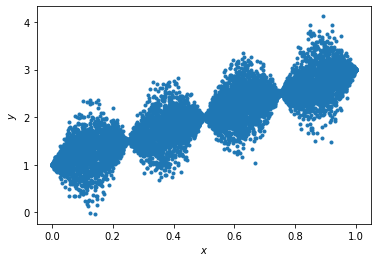

In [22]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)
x = np.random.random(n_samples)
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1  + eps
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

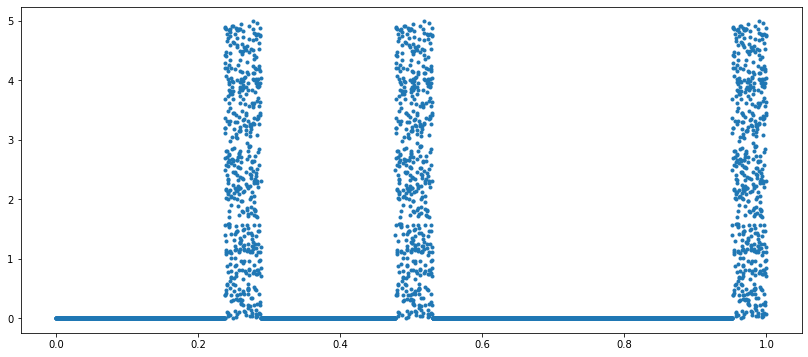

In [23]:
#generate noise
k_noise = 0
theta_noise = 5
n_noise_samples=500 #5% of samples
#offset to locate noise 
offset=int((n_samples-n_noise_samples)/2)
#padding_zeros=np.zeros(int((n_samples-n_noise_samples)/2),dtype=float)
partial_non_gaussian_noise = np.random.uniform(k_noise, theta_noise, n_noise_samples)
#nonGaussianNoise=np.concatenate((padding_zeros, partialNonGaussianNoise,padding_zeros))
non_gaussian_noise=np.zeros(n_samples)
#x is a non-ordered array. In order to locate noise at a selected point, we need to order x and assing the y.
ordered_x=copy.deepcopy(x)
#ordered_x=x
ordered_x.sort()

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+offset]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+int(offset/2)]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+int(2*offset)]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]
plt.figure(figsize=(14,6))
plt.plot(x,non_gaussian_noise, '.')

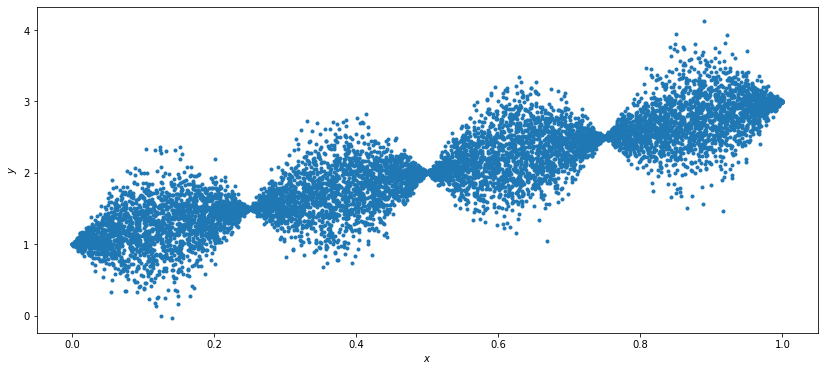

In [24]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

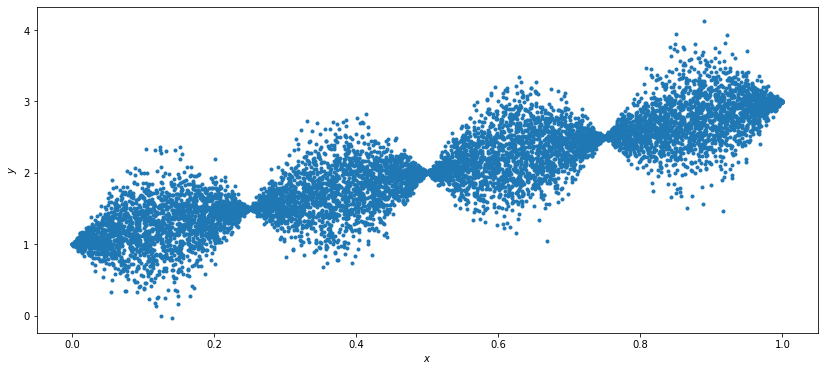

In [25]:
#add noise
y = y 
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [26]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(10000)
y = np.stack([y, sigma], axis=1)

In [27]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [28]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [29]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [30]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Create a simple network 

In [31]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [32]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [33]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [36]:
y_pred = model(x)
custom_loss(y_pred,y)

tensor(0.0657, grad_fn=<MseLossBackward>)

In [35]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    loss
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 3.88


KeyboardInterrupt: 

### Get predictions for validation set 

In [ ]:
# Get predicted y and sigma for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data

In [ ]:
for i in range(500):
    print(model(x_val_pytorch[i]))

### Plot results

In [ ]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

In [ ]:
m.r2_score(y_val[:,0],y_pred)

Original at: https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb

# Predicting uncertainty with (deep) neural networks

The idea is that a network that outputs a real-valued prediction can be (simply) modified to provide an estimate of the error on this prediction. Roughly speaking we do:

* Add an additional real-valued output to the network. The network now predicts two values: the output, $y$, and its error, $\sigma$

* Estimate the target value for the error, $\sigma$, from the difference between the target value of the output, $y$, and its predicted value, $\hat{y}$. We can use either: $\sigma^2 = (y-\hat{y})^2$ or $\sigma = \left| y-\hat{y}\right|$

* An easy way to do this at training time is with a customised loss function

### Imports 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import copy

%matplotlib inline

### Generate some random data

In [ ]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)
x = np.random.random(n_samples)
eps = np.random.uniform(low=-1.0, high=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
#eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1  + eps
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [ ]:
#generate noise
k_noise = 0
theta_noise = 5
n_noise_samples=500 #5% of samples
#offset to locate noise 
offset=int((n_samples-n_noise_samples)/2)
#padding_zeros=np.zeros(int((n_samples-n_noise_samples)/2),dtype=float)
partial_non_gaussian_noise = np.random.uniform(k_noise, theta_noise, n_noise_samples)
#nonGaussianNoise=np.concatenate((padding_zeros, partialNonGaussianNoise,padding_zeros))
non_gaussian_noise=np.zeros(n_samples)
#x is a non-ordered array. In order to locate noise at a selected point, we need to order x and assing the y.
ordered_x=copy.deepcopy(x)
#ordered_x=x
ordered_x.sort()

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+offset]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+int(offset/2)]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]

for ordered_position in range(n_noise_samples):
    value_to_find=ordered_x[ordered_position+int(2*offset)]
    original_array_position=np.where(x==value_to_find)[0]
    non_gaussian_noise[original_array_position]=partial_non_gaussian_noise[ordered_position]
plt.figure(figsize=(14,6))
plt.plot(x,non_gaussian_noise, '.')

In [ ]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [ ]:
#add noise
y = y 
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [ ]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(10000)
y = np.stack([y, sigma], axis=1)

In [ ]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [ ]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [ ]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [ ]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

### Create a simple network 

In [ ]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [ ]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [ ]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [ ]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

### Get predictions for validation set 

In [ ]:
# Get predicted y and sigma for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data

In [ ]:
for i in range(500):
    print(model(x_val_pytorch[i]))

### Plot results

In [ ]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

In [ ]:
m.r2_score(y_val[:,0],y_pred)


# Full non gausian noise

Now we will repeat the same experiment but this time all the noise we add is going to be 
from a uniform distribution

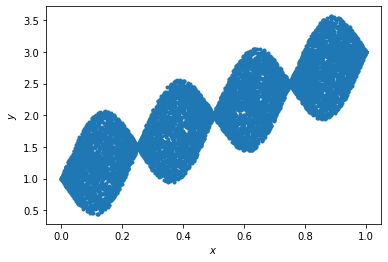

In [7]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)
x = np.random.random(n_samples)
eps = np.random.uniform(low=-2.0, high=2.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1  + eps
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [8]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(10000)
y = np.stack([y, sigma], axis=1)

In [9]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [10]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [11]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [12]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Create a simple network 

In [13]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [14]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [15]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [16]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 3.67
epoch:  500, loss: 0.0747
epoch: 1000, loss: 0.0743
epoch: 1500, loss: 0.0739
epoch: 2000, loss: 0.0736
epoch: 2500, loss: 0.0733
epoch: 3000, loss: 0.0729
epoch: 3500, loss: 0.0726
epoch: 4000, loss: 0.0722
epoch: 4500, loss: 0.0718
epoch: 5000, loss: 0.0714
epoch: 5500, loss: 0.071
epoch: 6000, loss: 0.0705
epoch: 6500, loss: 0.0701
epoch: 7000, loss: 0.0696
epoch: 7500, loss: 0.0691
epoch: 8000, loss: 0.0687
epoch: 8500, loss: 0.0683
epoch: 9000, loss: 0.0679
epoch: 9500, loss: 0.0677


### Get predictions for validation set 

In [17]:
# Get predicted y and sigma for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data

### Plot results

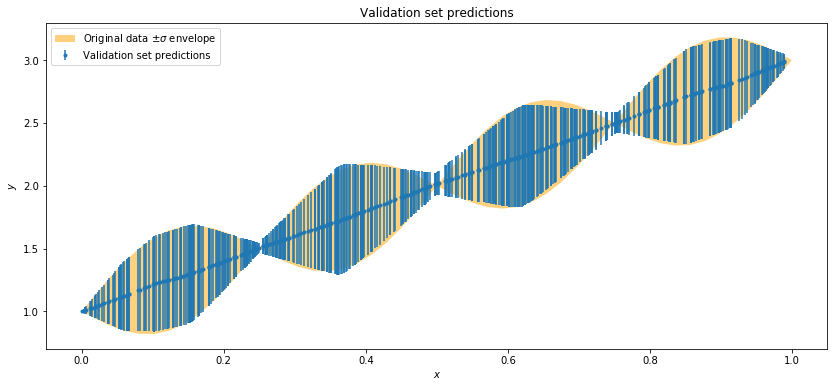

In [18]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

In [19]:
m.r2_score(y_val[:,0],y_pred)




0.7498104640081642